<h2><b>Họ và tên:</b> Phan Nguyễn Thành Nhân</h2>
<h2><b>MSSV:</b> 19521943</h2>
<h2><b>Lớp:</b> CS116.M12.KHCL</h2>

#TUTORIAL: LOCAL FEATURE BASED VISUAL SEARCH


# Step 1 - Preparation
This step setups a connection between the Colab server to the Google Drive server (authenticated by your Google account). By this way, you can synchronize the computational machine with your personal data.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Check GDrive connection
# NOTE: You should change this path based on your real configuration
tutorial_path = '/content/drive/MyDrive/Hoc_Tap/CS231_CV/feature_matching/'
%cd '$tutorial_path'

/content/drive/MyDrive/Hoc_Tap/CS231_CV/feature_matching


Next step, please install OpenCV version 3.4.2.17 (checked, not sure for other even new version)

In [5]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.6 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 1.7 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


Test the installation progress is success or not.

In [6]:
%matplotlib inline
import sys
# Works in command line but for Jupyter including cv2 python env necessary. I guess it's part of python lib hell
import cv2
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Step 2 - Read and display image

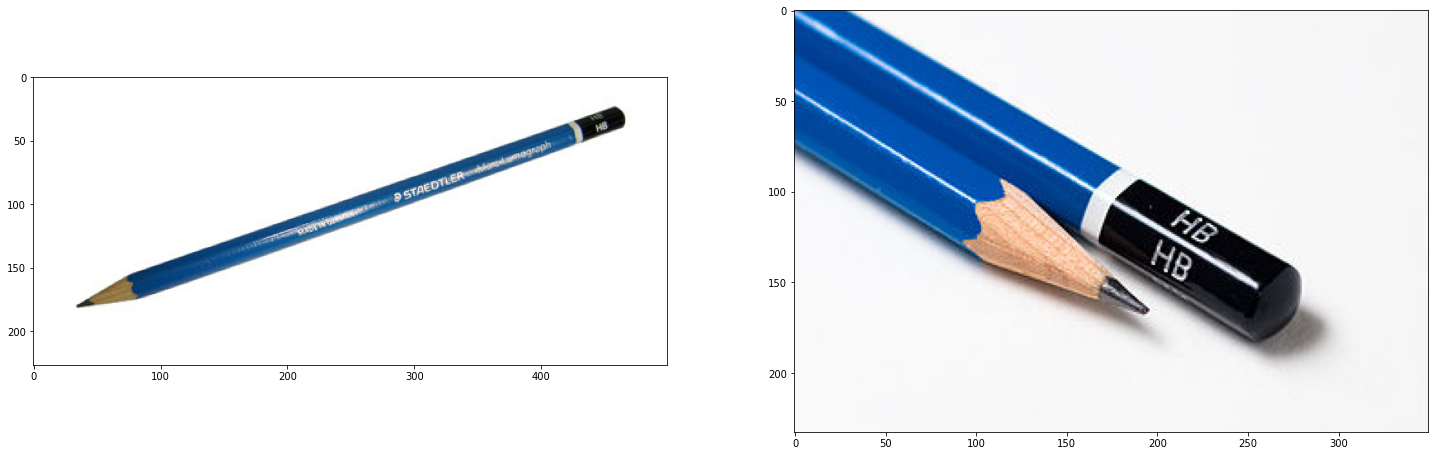

In [56]:
# img1_path = '/content/drive/MyDrive/Hoc_Tap/CS231_CV/feature_matching/ThuyChi_1.jpg'
# img2_path = '/content/drive/MyDrive/Hoc_Tap/CS231_CV/feature_matching/ThuyChi_crop.jpg'
# img_path = '/content/drive/MyDrive/Hoc_Tap/CS231_CV/feature_matching/ThuyChi_2.jpg'
img1_path = '/content/drive/MyDrive/Hoc_Tap/CS231_CV/feature_matching/pencil1.jpg'
img2_path = '/content/drive/MyDrive/Hoc_Tap/CS231_CV/feature_matching/pencil.jpg'
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
fig = plt.figure(figsize=(25, 50)) # parallel display of images
fig.add_subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
fig.add_subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

# Step 3 - Detect and describe SIFT features

In [57]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
#img_with_kp = cv2.drawKeypoints(img1,kp1,img_with_kp)

# Step 4 - Match local features using FLANN (Fast Library for Approximate Nearest Neighbor)

In [58]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Step 5 - Visualize results

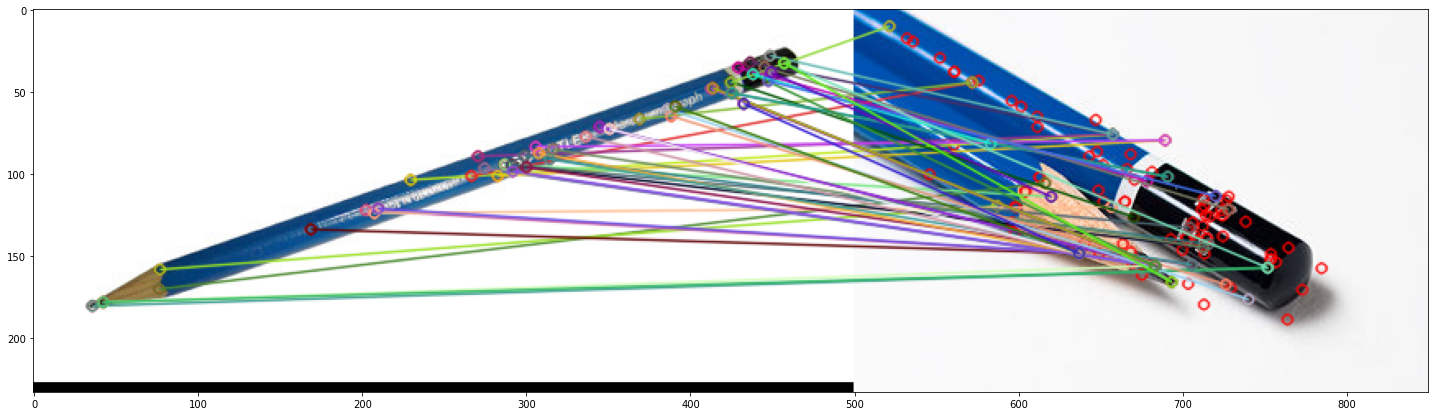

(<matplotlib.image.AxesImage at 0x7f8b224e5250>, None)

In [66]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    # if m.distance < 0.7*n.distance:
    matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
draw_params = dict(singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize=(25, 50))
plt.imshow(img3,),plt.show()

In [67]:
cv2.imwrite(tutorial_path + 'raw.png', cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

True

# Step 6 - RANSAC

## RANSAC

In [61]:
import random
n_random = 3
n_ = -np.inf
H_ = []
threshold = 0.85
for _ in range(5000):
    random_idxs = random.sample(range(len(matches)), n_random)
    random_points_X = np.asarray(kp1)[random_idxs]

    random_idxs_ = [i.trainIdx for i in np.asarray(matches)[random_idxs][:,0]]
    random_points_X_ = np.asarray(kp2)[random_idxs_]

    M = np.array([[i.pt[0] for i in random_points_X],[i.pt[1] for i in random_points_X],[1 for i in range(n_random)]])
    M_ = np.array([[i.pt[0] for i in random_points_X_],[i.pt[1] for i in random_points_X_],[1 for i in range(n_random)]])
    # for i in random_points_X:
    #     print(i.pt, end=' ')
    try:
        H = np.dot(M_, np.linalg.inv(M))
    except:
        # H = np.dot(M_, np.linalg.inv(M+0.00001*np.random.rand(*M.shape)))
        continue
    n_inliner = 0
    for i in range(len(matches)):
        x = np.asarray(list(kp1[i].pt)+[1])
        x_ = np.asarray(list(kp2[np.asarray(matches)[i,0].trainIdx].pt)+[1])
        x__ = np.dot(H, x)

        d1 = np.linalg.norm(x-x_)
        d2 = np.linalg.norm(x-x__)
        ratio = d2/d1
        if ratio >= threshold and ratio <= 1+1-threshold:
            n_inliner += 1
    
    if n_inliner > n_:
        n_ = n_inliner
        print('update n_inliner: ',n_)
        H_ = H.copy()

update n_inliner:  25
update n_inliner:  26
update n_inliner:  27
update n_inliner:  30
update n_inliner:  31
update n_inliner:  32
update n_inliner:  34


## Visualize RANSAC

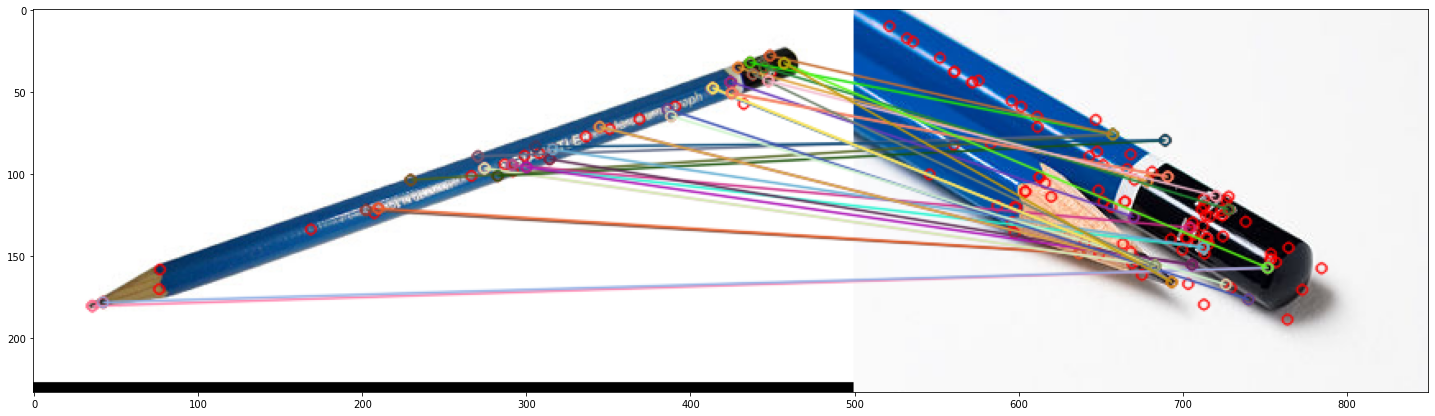

(<matplotlib.image.AxesImage at 0x7f8b222e9b50>, None)

In [62]:
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# Decrease threshold to get more matches or increase to get less than
new_threshold  = threshold 
for i,(m,n) in enumerate(matches):
    x = np.asarray(list(kp1[i].pt)+[1])
    x_ = np.asarray(list(kp2[np.asarray(matches)[i,0].trainIdx].pt)+[1])
    x__ = np.dot(H_, x)
    d1 = np.linalg.norm(x-x_)
    d2 = np.linalg.norm(x-x__)
    ratio = d2/d1
    if ratio >= new_threshold and ratio <= 1+1-new_threshold:
        matchesMask[i] = [1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
draw_params = dict(singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize=(25, 50))
plt.imshow(img3,),plt.show()

In [64]:
cv2.imwrite(tutorial_path + 'results.png', cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

True